<div style="text-align: center; margin-top: 50px;">
  <h1>Monthly Consumer Prices  in Spain</h1>
  <p><em>Daniel Losada y Gabriel Pons</em></p>
</div>


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts

<!--# 1. Load data-->


In [33]:
%%capture

# Load the Excel file
file_path = "data/INE_IPC.xlsx"  # Path to the file
df = pd.read_excel(file_path).rename(columns={"    Índice general": "ig", 'Unnamed: 0': 'date'})[['date', 'ig']]#.set_index('date')

# Convert 'date' from "yyyyMmm" format to datetime
df['date'] = pd.to_datetime(df['date'].astype(str).str[:4] + '-' + df['date'].astype(str).str[5:7])

# Set the index to the new datetime format
df = df.set_index('date')

# Display the first few rows
print(df.head())


                ig
date              
2002-01-01  69.530
2002-02-01  69.590
2002-03-01  70.165
2002-04-01  71.118
2002-05-01  71.374


 $$
   P_t = \alpha + \beta \cdot t + \varepsilon_t,
   $$

<Axes: title={'center': 'Índice general'}, xlabel='Date', ylabel='Índice general'>

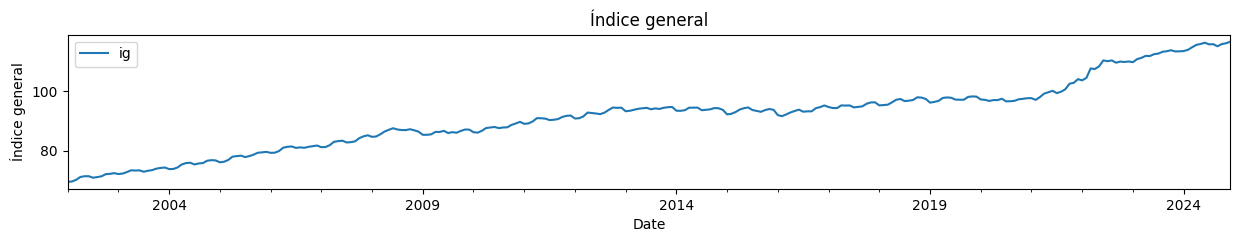

In [34]:
#plot the data
df.plot(figsize=(15, 2), title="Índice general", ylabel="Índice general", xlabel="Date")

**Time Series Plot ($\text{Indice general}$)**  
   The graph shows a steadily increasing trend in the CPI from 2002 through 2024, with an especially pronounced rise in recent years.  
   The visual evidence suggests that the data do not fluctuate around a constant mean but rather exhibit a long-run upward movement, implying that a simple deterministic trend or constant term may be insufficient to capture the non-stationarity.

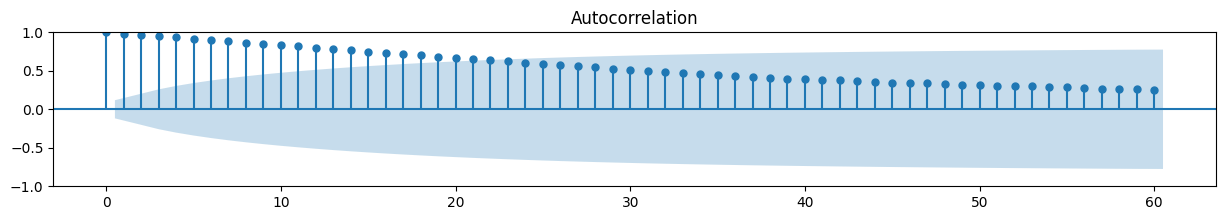

In [35]:
# Create the autocorrelation plot
fig, ax = plt.subplots(figsize=(15, 2))  # Adjust figure size to match the provided image
sm.graphics.tsa.plot_acf(df['ig'].dropna(), lags=60, ax=ax)

# Show the plot
plt.show()


**Autocorrelation Function (ACF)**  
   The ACF remains very high and decays slowly over many lags, a hallmark of a process with strong persistence.  
   If the series were stationary , the ACF would decay much more rapidly. Instead, the slow decay reinforces the idea that the series is driven by a stochastic trend. The ACF is particularly useful in detecting seasonality. As the ACF doesn't exhibit significant spikes at lags like for example $12$, $24$, $36$, etc., this is a strong indication of none seasonality in the data.

In [36]:
# Perform the standard Dickey-Fuller test (without automatic lag selection)
df_test = ts.adfuller(df['ig'].dropna(), autolag=None)  # No extra lags, basic DF test

# Print test results
print(f"Dickey-Fuller test statistic: {df_test[0]:.4f}")
print(f"P-value: {df_test[1]:.4f}")
print(f"Critical values: {df_test[4]}")

if df_test[1] < 0.05:
    print("Reject the null hypothesis (H0): The series is stationary.")
else:
    print("Fail to reject H0: The series is non-stationary (unit root present).")

Dickey-Fuller test statistic: 0.0837
P-value: 0.9649
Critical values: {'1%': np.float64(-3.4558530692911504), '5%': np.float64(-2.872764881778665), '10%': np.float64(-2.572751643088207)}
Fail to reject H0: The series is non-stationary (unit root present).


**Dickey-Fuller Test**    
   - **P-value**: $0.9649$ indicates strong evidence that the level of the series remains non-stationary.

In order to obtain the stationary transformation, **estimating the trend using Ordinary Least Squares (OLS)** will cast the following **residuals:**
   $$
   \hat{\varepsilon}_t = P_t - \left( \hat{\alpha} + \hat{\beta} \cdot t \right)
   $$


In [37]:
# Create a time index (trend variable)
df['t'] = np.arange(len(df))  

# Fit a linear trend model: P_t = α + βt + ε_t
X = sm.add_constant(df['t'])  # Add intercept
model = sm.OLS(df['ig'], X).fit()
df['residuals_det'] = model.resid  # Stationary transformation

In [38]:
%%capture
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     ig   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     3418.
Date:                Wed, 05 Mar 2025   Prob (F-statistic):          9.01e-157
Time:                        11:40:02   Log-Likelihood:                -702.47
No. Observations:                 276   AIC:                             1409.
Df Residuals:                     274   BIC:                             1416.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         72.5745      0.372    195.296      0.000      71.843      73.306
t              0.1367      0.002     58.464      0.000       0.132       0.141
==============================================================================
Omnibus:                       14.499   Durbin-Watson:                   0.034
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                6.283
Skew:                          -0.067   Prob(JB):                       0.0432
Kurtosis:                       2.273   Cond. No.                         317.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

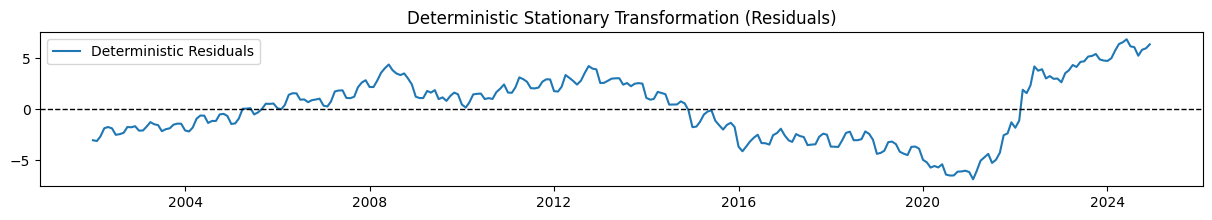

In [39]:
plt.figure(figsize=(15, 2))
plt.plot(df.index, df['residuals_det'], label="Deterministic Residuals")
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.title("Deterministic Stationary Transformation (Residuals)")
plt.legend()
plt.show()

To **Check stationarity** The residuals must be plotted to examine their behavior and running Dickey–Fuller test on $\hat{\varepsilon}_t$ to check the conclusions. Only looking at the graph it's already clear that the residuals don't have a stationary behaviour. Anyway, it will be checked afterwards using the Dickey-Fuller Test. 

When we assume that a series is stochastic, it's nonstationarity is due to a unit root rather than a deterministic trend. This means the series has a stochastic trend, often modeled as a random walk. For example, consider the following model:

$$
P_t = P_{t-1} + \varepsilon_t,
$$

where $\varepsilon_t$ is a white noise process. In this case, the variance of $P_t$ increases over time and the series is nonstationary.

When assuming the series is stochastic, in order to obtain a stationary series, we need to remove this stochastic trend. The common approach is to difference the series. The first difference is defined as:

$$
\Delta P_t = P_t - P_{t-1} = \varepsilon_t \space and \space E(\Delta P_t) = E(\eta_t) + (\Delta \varepsilon_t) = 0
$$

Since $\varepsilon_t$ is stationary by assumption, $\Delta P_t$ will also be stationary. This differencing stabilizes the mean of the series, making it suitable for further analysis or modeling.

<!-- # 3. B -->

In [40]:
# Apply first differencing
df['diff_ig'] = df['ig'].diff()
# Apply second differencing (stochastic transformation)
df['diff2_ig'] = df['diff_ig'].diff()

'# Plot the transformations\nplt.figure(figsize=(12, 6))\n\nplt.subplot(3, 1, 1)\nplt.plot(df[\'ig\'], label="Original Series")\nplt.title("Original Series")\nplt.legend()\n\nplt.subplot(3, 1, 2)\nplt.plot(df[\'diff_ig\'], label="First Difference", color=\'orange\')\nplt.title("First Difference")\nplt.legend()\n\nplt.subplot(3, 1, 3)\nplt.plot(df[\'diff2_ig\'], label="Second Difference", color=\'green\')\nplt.title("Second Difference (Stationary Transformation)")\nplt.legend()\n\nplt.tight_layout()\nplt.show()\n'

### Series Comparison 

#### ACF and PACF

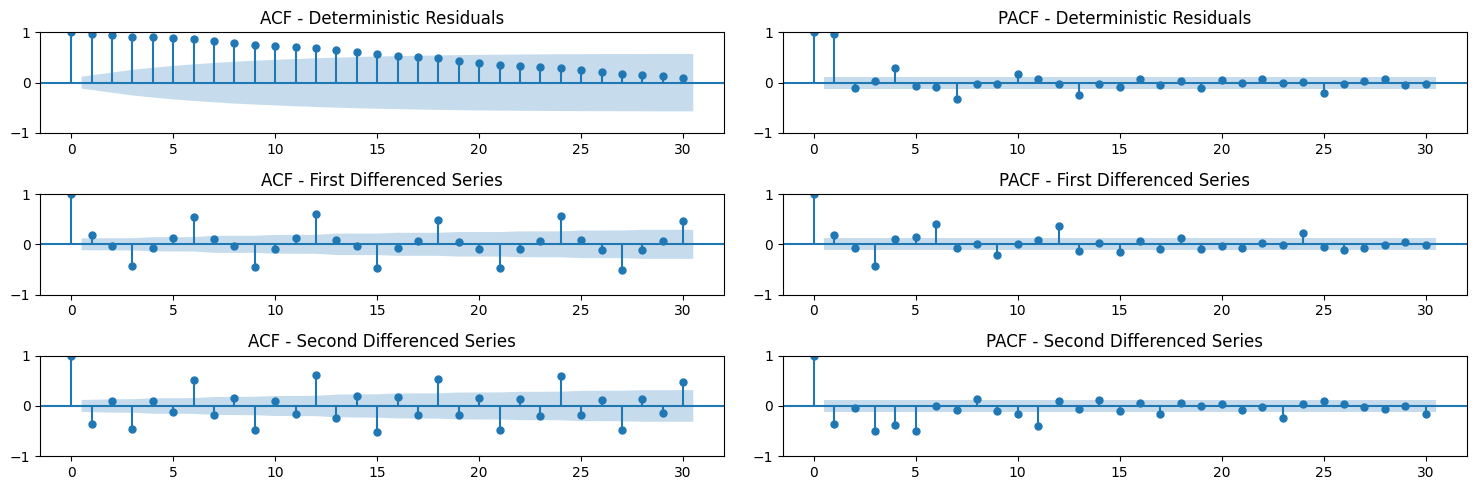

In [41]:
# Autocorrelation comparison
fig, ax = plt.subplots(3, 2, figsize=(15, 5))

# ACF for deterministic residuals
sm.graphics.tsa.plot_acf(df['residuals_det'].dropna(), lags=30, ax=ax[0, 0])
ax[0, 0].set_title("ACF - Deterministic Residuals")

# PACF for deterministic residuals
sm.graphics.tsa.plot_pacf(df['residuals_det'].dropna(), lags=30, ax=ax[0, 1])
ax[0, 1].set_title("PACF - Deterministic Residuals")

# ACF for first differenced series
sm.graphics.tsa.plot_acf(df['diff_ig'].dropna(), lags=30, ax=ax[1, 0])
ax[1, 0].set_title("ACF - First Differenced Series")

# PACF for first differenced series
sm.graphics.tsa.plot_pacf(df['diff_ig'].dropna(), lags=30, ax=ax[1, 1])
ax[1, 1].set_title("PACF - First Differenced Series")

# ACF for second differenced series
sm.graphics.tsa.plot_acf(df['diff2_ig'].dropna(), lags=30, ax=ax[2, 0])
ax[2, 0].set_title("ACF - Second Differenced Series")

# PACF for second differenced series
sm.graphics.tsa.plot_pacf(df['diff2_ig'].dropna(), lags=30, ax=ax[2, 1])
ax[2, 1].set_title("PACF - Second Differenced Series")

plt.tight_layout()
plt.show()

#### Dickey Fuller test

In [42]:
alpha = 0.05
# Dickey-Fuller
print("\nDickey-Fuller Test for Deterministic Residuals:")
adf_det = ts.adfuller(df['residuals_det'].dropna())
print(f"ADF Statistic: {adf_det[0]:.4f}, p-value: {adf_det[1]:.4f}")
if adf_det[1] < alpha:
    print("Reject the null hypothesis (H0): The series is stationary.")
else:
    print("Fail to reject H0: The series is non-stationary (unit root present).")


print("\nDickey-Fuller Test for First Differencing:")
adf_det = ts.adfuller(df['diff_ig'].dropna())
print(f"ADF Statistic: {adf_det[0]:.4f}, p-value: {adf_det[1]:.4f}")
if adf_det[1] < alpha:
    print("Reject the null hypothesis (H0): The series is stationary.")
else:
    print("Fail to reject H0: The series is non-stationary (unit root present).")

print("\nDickey-Fuller Test for Second Differencing:")
adf_stoch = ts.adfuller(df['diff2_ig'].dropna())
print(f"ADF Statistic: {adf_stoch[0]:.4f}, p-value: {adf_stoch[1]:.4f}")
if adf_stoch[1] < alpha:
    print("Reject the null hypothesis (H0): The series is stationary.")
else:
    print("Fail to reject H0: The series is non-stationary.")


Dickey-Fuller Test for Deterministic Residuals:
ADF Statistic: -1.9667, p-value: 0.3013
Fail to reject H0: The series is non-stationary (unit root present).

Dickey-Fuller Test for First Differencing:
ADF Statistic: -3.2760, p-value: 0.0160
Reject the null hypothesis (H0): The series is stationary.

Dickey-Fuller Test for Second Differencing:
ADF Statistic: -6.0723, p-value: 0.0000
Reject the null hypothesis (H0): The series is stationary.


In [43]:
summary_df = pd.concat([
    df['residuals_det'].describe(),
    df['diff_ig'].describe(),
    df['diff2_ig'].describe()
], axis=1)

summary_df.columns = ['Deterministic Residuals', 'Diff IG', 'Second Differencing']
print("\nSummary Statistics:\n", summary_df)


Summary Statistics:
        Deterministic Residuals     Diff IG  Second Differencing
count             2.760000e+02  275.000000           274.000000
mean              1.318108e-14    0.170924             0.001693
std               3.089612e+00    0.570287             0.732314
min              -6.874271e+00   -1.787000            -3.354000
25%              -2.408275e+00   -0.111000            -0.503000
50%               4.369855e-01    0.173000             0.028500
75%               2.412955e+00    0.498000             0.552750
max               6.861122e+00    3.163000             2.327000


The deterministic residuals approach shows a slow decay in the ACF plot, with autocorrelations remaining positive for many lags. The Dickey–Fuller test for this method fails to reject the null hypothesis of a unit root ($p$-value $\approx 0.30$), indicating that the residual series is still nonstationary. In other words, merely removing a linear trend did not fully eliminate the stochastic component, leaving significant serial dependence in the data. On the other hand, their statistical properties show that the residuals that are perfectly centered at zero, indicating that the trend component has been removed. However, the high standard deviation and wide range suggest substantial dispersion in the residuals. This may imply that, despite removing the deterministic trend, significant stochastic variability remains in the series.

In contrast, when first differencing is applied, the ACF decays much more rapidly, and the Dickey–Fuller test rejects the null hypothesis of a unit root ($p$-value $\approx 0.016$). This suggests that the first-differenced series is stationary. Although the ACF indicates some remaining structure, the overall reduction in long-run persistence demonstrates that first differencing effectively stabilizes the series. Regard that the significance level chosen to assume stationarity is $\alpha = 0.05$. If $\alpha = 0.01$ is chosen, we would have to reject stationarity. Taking a look to the statistics they show a low standard deviation and a mean that is close to zero. This indicates that first differencing effectively removes the unit root and stabilizes the variance, though a small drift remains. The more contained range further supports the improved stability of the series.

When second differencing is performed, the ACF continues to show relatively low correlations, and the Dickey–Fuller test strongly rejects the unit root hypothesis ($p$-value $\approx 0.000$). However, while the second-differenced series is very well centered around zero, its standard deviation is slightly higher and its range wider than that of the first-differenced series. This indicates that, although any residual drift is removed more completely, the series may be over-differenced, potentially introducing extra noise or negative autocorrelation at the first lag.

Remark that both differences have a clear pattern in their correlations, showing a seasonal trend every six months.

Based on the analysis, first differencing emerges as the most appropriate transformation. The deterministic approach indicates persistent nonstationarity, while the high dispersion in the residuals points to remaining stochastic variability. On the other hand, although second differencing achieves strong stationarity by completely eliminating any drift, it appears to over-difference the series, potentially introducing extra noise. In contrast, the first-differenced series is the best compromise for stabilizing the series.
